<a href="https://colab.research.google.com/github/waltatgit/deeplearning/blob/master/Multi_Class_Text_Classification_with_Keras_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Definition

For our problem definition, we’ll try to solve the problem on the text classification on BBC News articles and its category. Based on the given text as an input, we will predict what would be the category. We have five type of categories: business, entertainment, politics, sport and tech.

### Import the Libraries

Firstly, we will import the necessary libraries like TensorFlow, Numpy and CSV.

In [49]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from keras.callbacks import EarlyStopping


### Get the Data

We need a data for our model, we will get the data from https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv and save it in a /tmp folder with the file name bbc-text.csv.


In [50]:
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-08-21 19:56:58--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2020-08-21 19:56:58 (217 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



### Import NTLK Library

Import ntlk library and  the stopwords function. We will set the stopwords for English language. These are the samples for English stopwords: has, hasn’t, and, aren’t, because, each, during.

In [51]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Set the Hyper-Parameters
We set the hyper-Parameters that are required to build and train the model.


In [52]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

### Populate List and Remove the Stopwords
We populate the list of articles and labels from the data and also remove the stopwords.


In [53]:
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

### Create Training and Validation Set
Then we need to split them into training set and validation set. We set 80% (training_portion = .8) for training and another 20% for validation.


In [54]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

### Tokenization

We set the tokenization with num_words is vocab_size (5000), and oov_token is ‘<OOV>’ . And we call the method fits_on_texts on train_articles. This method creates the vocabulary index based on word frequency.
For example if we give the text “The cat sat on the mat.”, it will create a dictonary {‘\<OOV\>’: 1, ‘cat’: 3, ‘mat’: 6, ‘on’: 5, ‘sat’: 4, ‘the’: 2}.
    
The oov_token is the value ‘\<OOV\>’ that we put if the word is not listed in the dictionary.

In [55]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

### Convert to Sequences
After tokenization, we call the method text_to_sequences. It transforms each text in texts to a sequence of integers. Basically, it takes each word in the text and replaces it with its corresponding integer value from the dictionary tokenizer.word_index. If the word is not in the dictionary, it will put the value of 1.
For example, if we give the text “the cat sat on my table”, we will get the sequence: [2, 3, 4, 5, 1, 1]. The last two [1,1] is for the word “my table” which is not in the dictionary.

In [56]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)

### Sequence Truncation and Padding
Those sequences are not in the same size, we need to make them in same size (concrete shape) when we train them for NLP. We need to use padding and truncate them so all sequences will be in the same size. We use post for padding_type and truncate_type

In [57]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Labels

We need to do the same thing here as we did before when we deal with the features, articles. As the model doesn’t understand the words, we need to convert the label into numbers. We do tokenization and convert to sequence as before. When doing the tokenization, we don’t indicate the vocab size and oov_token.

In [58]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

### Create Model
Now we are ready to create the sequential model. The model architecture consist of the following layers:

- Embedding Layer
The model begins with an embedding layer which turns the input integer indices into the corresponding word vectors. Word embedding is a way to represent a word as a vector. Word embeddings allow the value of the vector’s element to be trained. After training, words with similar meanings often have the similar vectors.

- Dropout Layer
Add the dropout layer to combat overfitting.

- BiDirectional with LSTM Layer
The BiDirectional layer propagates the input forward and backwards through the LSTM layer and then concatenates the output. This helps the LSTM to learn long range dependencies.

- Dense Layer
This the final layer, Dense layer with softmax activation for the multi class classification.



In [59]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

We then compile the model to configure the training process with the loss sparse_categorical_crossentropy since we didn’t one-hot encode the labels. We use RMSprop optimizer.


In [68]:
opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001
)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

### Train the Model
Now we are ready to train the model by calling the method fit().


In [69]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)

num_epochs = 100
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2,
                    callbacks=[es])

Epoch 1/100
56/56 - 2s - loss: 1.4805 - accuracy: 0.3573 - val_loss: 1.2450 - val_accuracy: 0.4876
Epoch 2/100
56/56 - 1s - loss: 0.9628 - accuracy: 0.6242 - val_loss: 0.6984 - val_accuracy: 0.7506
Epoch 3/100
56/56 - 1s - loss: 0.5278 - accuracy: 0.8275 - val_loss: 0.7770 - val_accuracy: 0.6697
Epoch 4/100
56/56 - 1s - loss: 0.2954 - accuracy: 0.9112 - val_loss: 0.2102 - val_accuracy: 0.9461
Epoch 5/100
56/56 - 1s - loss: 0.1606 - accuracy: 0.9567 - val_loss: 0.1404 - val_accuracy: 0.9663
Epoch 6/100
56/56 - 1s - loss: 0.1281 - accuracy: 0.9635 - val_loss: 0.1459 - val_accuracy: 0.9618
Epoch 7/100
56/56 - 1s - loss: 0.0573 - accuracy: 0.9860 - val_loss: 0.1686 - val_accuracy: 0.9483
Epoch 8/100
56/56 - 1s - loss: 0.0339 - accuracy: 0.9899 - val_loss: 0.3031 - val_accuracy: 0.8966
Epoch 9/100
56/56 - 1s - loss: 0.0144 - accuracy: 0.9972 - val_loss: 0.2927 - val_accuracy: 0.9371
Epoch 10/100
56/56 - 1s - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.2489 - val_accuracy: 0.9326


### Plot the graph

We plot the history for accuracy and loss and see if there is overfitting.


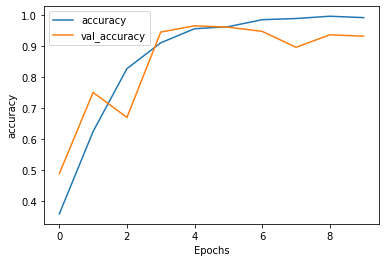

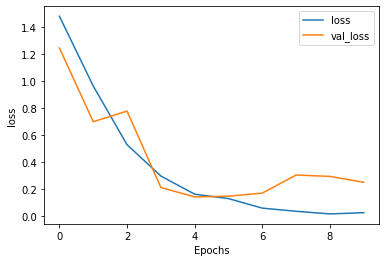

In [70]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Calculate classification metrics

In [63]:
#predicted = model.predict_classes(validation_padded)

In [71]:
from sklearn import metrics


In [72]:
predicted2 = model.predict(validation_padded)
predicted2 = np.argmax(predicted2, axis=-1)
print(metrics.classification_report(validation_label_seq, predicted2))


              precision    recall  f1-score   support

           1       0.98      0.93      0.95       101
           2       0.94      0.95      0.95       106
           3       0.98      0.95      0.96        86
           4       0.85      0.94      0.90        86
           5       0.90      0.86      0.88        66

    accuracy                           0.93       445
   macro avg       0.93      0.93      0.93       445
weighted avg       0.93      0.93      0.93       445

